## INFO

This is a notebook to highlight the Tweedie Compound Poisson Gamma Powe Estimation.

Current statsmodels procedures do not necessarily converge to optimial powers in comparison to R and SAS which appear to converge very similarly. In some cases, the power estimate in statsmodels fails altogether when it determines the power is optimally outside of the bounds of 1.01 and 1.99. Research brought up the incredible effort place by @thequackdaddy and this convergence attempt here uses his Tweedie Distribution package found here: https://github.com/thequackdaddy/tweedie

Additional resources:
- https://cran.r-project.org/web/packages/HDtweedie/HDtweedie.pdf
- https://www.math.mcgill.ca/yyang/resources/papers/JCGS_HDtweedie.pdf
- https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.643.9431&rep=rep1&type=pdf

Please note that TCPG is only valid for solutions of powers between 1.0 and 2.0.

<font color=blue size=4>**Links for comparison to SAS:**</font>
- https://stats.stackexchange.com/questions/400663/sas-and-r-gives-different-standard-error-when-fitting-tweedie-model
- *GEE Models not available for Tweedie Distribution*

In [1]:
## SOME EXTENSIONS MIGHT NOT LOAD 
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sma
import scipy as sp

from sklearn.metrics import mean_tweedie_deviance, mean_absolute_error
import os
import gc
import shap

pd.set_option('max_columns', 150)
pd.set_option('max_rows', 100)

import warnings
warnings.filterwarnings("ignore")

In [3]:
import getpass

In [4]:
username = getpass.getpass()
env_name = 'fnb'

 ·······


In [5]:
import os
##  you must then set your R HOME before importing the module - it should be in a similar location as below
os.environ['R_HOME'] = f'C:/Users/{username}/Anaconda3/envs/{env_name}/Lib/R'

In [6]:
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2 import robjects
import rpy2
pandas2ri.activate()

import sys
print("Python version should be 3.7.9.")
print("Current Python Version: {}".format(sys.version))
print("rpy2 Version = ", rpy2.__version__)

print("\nR VERSION = ", r.version)

Python version should be 3.7.9.
Current Python Version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
rpy2 Version =  3.4.5

R VERSION =                 _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        



## Fish Data

I cant find the link but there are 5 variables where FISH_COUNT is our dependent variable based on how many were caught.

In [7]:
fish_data = pd.read_csv('data/fish.csv')
fish_data.head()

LIVE_BAIT  CAMPER  PERSONS  CHILDREN  FISH_COUNT
0          0       0        1         0           0
1          1       1        1         0           0
2          1       0        1         0           0
3          1       1        2         1           0
4          1       0        1         0           1

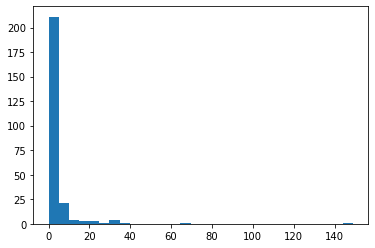

In [8]:
xf = fish_data.drop('FISH_COUNT',axis=1)
yf = fish_data['FISH_COUNT']

plt.hist(yf, bins=30);

**Here we see the distribution of the fishing data highlighting that it has a mass at zero and is discrete.**

In [9]:
(yf == 0).sum() / len(yf)

0.568

The data is about 56.8% 0.

**We must scale the exogenous variables (all others but y) to get an accurate assessment.**

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = xf.copy() 
y = yf.values.reshape(-1,1)
xfs = pd.DataFrame(X, columns=xf.columns, index=xf.index)

xf.describe()

LIVE_BAIT      CAMPER    PERSONS    CHILDREN
count  250.000000  250.000000  250.00000  250.000000
mean     0.864000    0.588000    2.52800    0.684000
std      0.343476    0.493182    1.11273    0.850315
min      0.000000    0.000000    1.00000    0.000000
25%      1.000000    0.000000    2.00000    0.000000
50%      1.000000    1.000000    2.00000    0.000000
75%      1.000000    1.000000    4.00000    1.000000
max      1.000000    1.000000    4.00000    3.000000

### STATSMODELS - PYTHON

In [11]:
## intial estimation, HC3 error
p0 = 1.5

twd = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=p0, eql=True))

# twd = sma.GLM(endog=data2.PurePremium, exog=sma.add_constant(data2.drop('PurePremium',axis=1)), 
#               exposure=data2.Exposure,
#               family=sma.families.Tweedie(var_power=p0, eql=True))

res = twd.fit(maxiter=1000, tol=1e-12)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      245
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    log   Scale:                          7.4412
Method:                          IRLS   Log-Likelihood:                -553.55
Date:                Thu, 14 Apr 2022   Deviance:                       859.06
Time:                        12:34:29   Pearson chi2:                 1.82e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0817      0.707     -4.360      0.0

**ReEstimate Tweedie Power with StatsModels**

In [12]:
twd.estimate_tweedie_power(res.mu)

1.630742735857726

Statsmodels optimizes to 1.63, now re-estimate with R version...which we cant due to a different error. However, the R estimate for the fish data is **1.41**, which is quite different from the Statsmodels power. Now, many articles and research highlight the possibility of BiModal points in the power estimation suggestion that there could be  more than 1 "optimal power" but we should strive to attempt to match R and SAS as statistical leaders in this area.  

In [13]:
def r_tweedie_power_est(y, X, figsize=None):
    '''
        R Based Tweedie Power Estimate
        y = pandas series or data frame
        X = pandas data frame

        The R function runs tweedie model profile with log link (0) over
        vector range np.arange(1.1, 1.95, 0.05).

        returns: power_estimate, loglikelihoods, power_range
    '''
    import re
    from rpy2.robjects import r
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
    from rpy2 import robjects
    import rpy2
    pandas2ri.activate()

    rmass = importr('MASS')
    rstats = importr('stats')
    rbase = importr('base')
    rtweed = importr('tweedie')

    rdf = pd.concat([y, X], axis=1) ## R data frame
    y_name = y.name if type(y) == pd.core.series.Series else y.columns[0] ## y needs to be a series

    profile = rtweed.tweedie_profile('{} ~ .'.format(y_name), data=rdf,
                                     link_power=0,
                                     xi_vec=np.arange(1.05, 1.95, 0.05))

    loglik = profile.rx2['y']
    power_rng = profile.rx2['x']
    xi_max = profile.rx2['xi.max']

    if figsize is not None:
        fig, ax=plt.subplots(1,1,figsize=figsize)
        plt.scatter(power_rng, loglik)
        ax.axvline(xi_max)
        ax.set_ylabel("Log Likelihood")
        ax.set_xlabel("Power Range")
        ax.legend(['Power Est = {}'.format(np.round(xi_max[0],4))])
        ax.set_title("R Power Estimation");
    return xi_max[0], loglik, power_rng

In [14]:
print("Estimated Tweedie Power using R Method Built into TweedieElasticNet")
etp = r_tweedie_power_est(yf, sma.add_constant(xfs), figsize=None)
print(etp[0])

Estimated Tweedie Power using R Method Built into TweedieElasticNet
1.05 1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
..................Done.
1.3969387755102045


116.74432130849385


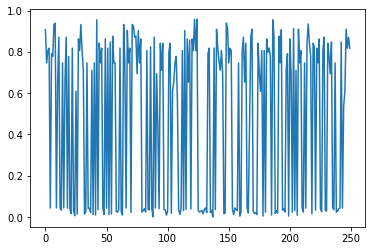

In [15]:
import tweedie_dist ## QUACK DADDY IMPLEMENTATION
import scipy as sp
twdgen = tweedie_dist.tweedie_gen()

## pdf according to quackdaddy
# density = twdgen._pdf(yf, p0, res.mu, res.scale)
density = tweedie_dist.tweedie(mu=res.mu, p=p0, phi=res.scale).pdf(yf)
print(density.sum())
plt.plot(density);

In [16]:
# help(tweedie_dist.)

In [1]:
def loglike_p(p, res):
    '''return the loglikehood measurement based on the density'''
    return -tweedie_dist.tweedie(mu=res.mu, p=p, phi=res.scale).logpdf(res._endog).sum()

def optm(p, res):
    '''optimization call to minimize scalar'''
    opt = sp.optimize.minimize_scalar(loglike_p, tol=1e-20, 
                                      bounds=(1.05, 1.95), args=(res), method='bounded')
    return opt

def tweedie_profile_sm(X, y, p=None, tolf=1e-20, figsize=None):
    ''' Convergence protocol for optimization.
        X = exogenous data (need to add constant if necessary)
        y = endogenous data
        p = power or list of powers to check within
        tolf = scipy.optimize.minimize_scaler() tolerance call
        figsize = None, if not None figsize of power optimiztion
            Note that this figure is not the traditional "arch" for LLF but an examination
            at the optimization pattern.
        
        scale = 'dev' in statsmodels GLM fit call as this matches closely with R / SAS
        
        RETURNS: a dataframe of optimized powers per p in power range
        
        eg
        power_ests = tweedie_profile_sm(statsmodels.add_constant(X),y)
        print(power_ests[power_ests.fval == power_ests.fval.min()]['p_new'])
        
        comparions with R:
                        R  |  Python
        Fish Data:  1.3969 |  1.3986
        Boston Housing Data:  1.119 | 1.12
        Random Tweedie Dist Samples:
        R Estimate = 1.51837,  Python Estimate = 1.50999
        R Estimate = 1.53571,  Python Estimate = 1.53841
        R Estimate = 1.37959,  Python Estimate = 1.32687
        R Estimate = 1.50816,  Python Estimate = 1.46346
        R Estimate = 1.41429,  Python Estimate = 1.38736
        R Estimate = 1.36224,  Python Estimate = 1.34728
        R Estimate = 1.50102,  Python Estimate = 1.49197
        R Estimate = 1.39694,  Python Estimate = 1.34821
        R Estimate = 1.41429,  Python Estimate = 1.39253
        R Estimate = 1.44286,  Python Estimate = 1.36981
    '''
    pests = []
    if p is None:
        pwrs = np.arange(1.05,1.95,0.05)
    else:
        pwrs = np.array([p])
    for p_i in pwrs:
        p_new = np.round(p_i,2)
        tol0 = 1
        while tol0 > tolf:
            p0 = p_new
            mod = sma.GLM(endog=y, exog=X, family=sma.families.Tweedie(var_power=p_new, eql=True))
            res = mod.fit(maxiter=1000, tol=1e-12, scale='dev')
            optimal = optm(p0,res)
            p_new = optimal.x
            # pests.append(p)
            tol0 = p0 - p_new
        pests.append([np.round(p_i,2), p_new, optimal.fun])
    
    power_df = pd.DataFrame(pests, columns=['p_init','p_new','fval']).set_index('p_init')
    if figsize is not None:
        minp = power_df[power_df.fval == power_df.fval.min()]['p_new'].values
        locp = power_df[power_df.fval == power_df.fval.min()]['p_new'].index
        fig, ax=plt.subplots(1,1,figsize=figsize)
        power_df.fval.plot(ax=ax)
        ax.axvline(locp, color='r', alpha=0.5)
        ax.legend([f"Optimal P = {minp[0] :.5f}"]);                                                                                                                                    
    
    return power_df

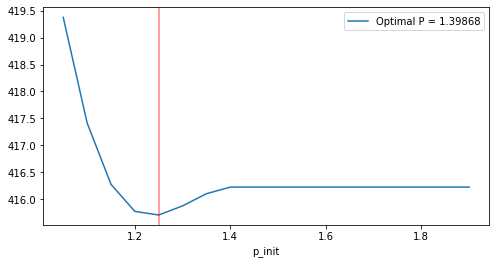

In [36]:
power_ests = tweedie_profile_sm(sma.add_constant(xfs), y, figsize=(8,4))
# print(power_ests)

### Boston Data but Edited

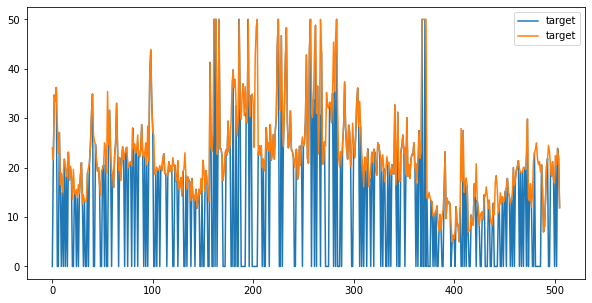

In [37]:
from sklearn.datasets import load_boston

boston = load_boston()
Xb = pd.DataFrame(boston.data, columns = boston.feature_names)
yb = pd.DataFrame(boston.target, columns=['target'])

##replace some data with 0
pct_to_zero = 0.35
samp_idx = yb.sample(frac=pct_to_zero, random_state=123).index

yb2 = yb.copy()
yb2[yb2.index.isin(samp_idx)] = 0

fig, ax=plt.subplots(1,1,figsize=(10,5))
yb2.plot(ax=ax)
yb.plot(ax=ax);

In [38]:
xbs = pd.DataFrame(scaler.fit_transform(Xb), columns=Xb.columns)
p0 = 1.5
twd = sma.GLM(endog=yb2, exog=sma.add_constant(xbs), family=sma.families.Tweedie(var_power=p0, eql=True))
res = twd.fit(maxiter=1000, tol=1e-12)
print(res.summary())
print(twd.estimate_tweedie_power(res.mu))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  506
Model:                            GLM   Df Residuals:                      492
Model Family:                 Tweedie   Df Model:                           13
Link Function:                    log   Scale:                          2.3556
Method:                          IRLS   Log-Likelihood:                -2305.0
Date:                Thu, 14 Apr 2022   Deviance:                       2977.4
Time:                        12:43:32   Pearson chi2:                 1.16e+03
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6121      0.036     72.882      0.0

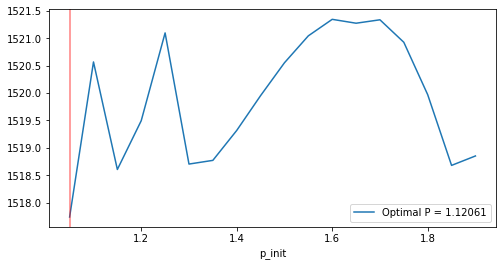

In [40]:
power_ests = tweedie_profile_sm(sma.add_constant(xbs), yb2, figsize=(8,4))
# print(power_ests)

**The R estimate for this one was 1.1 vs 1.13 for ours.**

In [41]:
print("Estimated Tweedie Power using R Method Built into TweedieElasticNet")
etp = r_tweedie_power_est(yb2, sma.add_constant(xbs), figsize=None)
print(etp[0])

Estimated Tweedie Power using R Method Built into TweedieElasticNet
1.05 1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
..................Done.
1.119387755102041


### More Trials

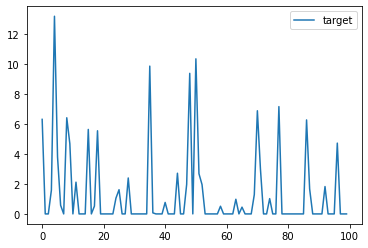

In [43]:
# Generating Poisson random sample
N = np.random.poisson(.5, 100)
rt = np.empty(100)
for i in range(100):
# Generate single data point of gamma distribution using poisson random variable
    rt[i] = np.random.gamma(N[i] * np.abs(-1.0), 2.5, 1)

yr = pd.DataFrame(rt, columns=['target'])
yr.plot();

In [46]:
for j in range(10):
    print(f"Iteration = {j}")
    # Generating Poisson random sample
    pois = np.random.poisson(.5, 100)
    rt = np.empty(100)
    for i in range(100):
    # Generate single data point of gamma distribution using poisson random variable
        rt[i] = np.random.gamma(pois[i] * np.abs(-1.0), 2.5, 1)

    yr = pd.DataFrame(rt, columns=['target'])
    pct_to_zero = 0.35
    samp_idx = yr.sample(frac=pct_to_zero, random_state=123).index

    yr2 = yr.copy()
    print(yr2.head().T)

    Xr = pd.DataFrame(sp.random.randn(100,5), columns=[f'x{i}' for i in range(1,6)])
    xrs = pd.DataFrame(scaler.fit_transform(Xr), columns=Xr.columns)
    p0 = 1.5
    twd = sma.GLM(endog=yr2, exog=sma.add_constant(xrs), family=sma.families.Tweedie(var_power=p0, eql=True))
    res = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)

    print("Estimated Tweedie Power using R Method Built into TweedieElasticNet and New Python...")
    etp = r_tweedie_power_est(yr2, sma.add_constant(xrs), figsize=None)
    print(f"R Estimate = {etp[0] :.5f}")
    power_ests = tweedie_profile_sm(sma.add_constant(xrs), yr2)    
    print(f"Python Estimate = {power_ests[power_ests.fval == power_ests.fval.min()]['p_new'].values[0] :.5f}")
    print("========================================================================\n")

Iteration = 0
          0         1    2    3    4
target  0.0  5.286558  0.0  0.0  0.0
Estimated Tweedie Power using R Method Built into TweedieElasticNet and New Python...
1.05 1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
..................Done.
R Estimate = 1.51837
Python Estimate = 1.50999

Iteration = 1
               0        1    2         3    4
target  6.849673  0.35265  0.0  7.114477  0.0
Estimated Tweedie Power using R Method Built into TweedieElasticNet and New Python...
1.05 1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
..................Done.
R Estimate = 1.53571
Python Estimate = 1.53841

Iteration = 2
               0         1         2         3    4
target  3.856439  9.095419  0.347542  0.937983  0.0
Estimated Tweedie Power using R Method Built into TweedieElasticNet and New Python...
1.05 1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
..................Done.
R Estimate = 1.3

### All things considered, this optimization method isnt too terrible.

In [ ]:
break

### R Model Comparison ?

link.power = 0 is the log link

**R Code:**

library(tweedie)
library(statmod)
library(lmtest)
library(sandwich)

df <- read.csv(data='data/fish.csv')

m1 <- glm(FISH_COUNT~., data=df, family=tweedie(var.power=1.4, link.power=0))

summary(m1)

coeftest(m1, vcov=vcovHC(m1, type='HC3'))

coeftest(m1, vcov=NeweyWest(m1, lag=12, prewhite=F))

In [40]:
# from statsmodels.iolib import SimpleTable
# from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)

In [41]:
# def r_summary_model(model, X):
#     """ Create a dict with information about the model """
#     import datetime as dt
#     from statsmodels.iolib import SimpleTable
#     from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)
#     from statsmodels.iolib.summary import forg
# #         model = self.model

#     info = {}
#     info['Model:'] = 'Tweedie with Varying Error Types'
#     info['Date:'] = dt.datetime.now().strftime('%Y-%m-%d %H:%M')
#     info['Df Model:'] = rbase.summary(model).rx2('df')[0]
#     info['Df Residuals:'] = model.rx2('df.residual')[0]
# #     info['Converged:'] = rbase.summary(model).rx2('converged')[0]
#     info['Deviance:'] = rbase.summary(model).rx2('deviance')[0]
#     info['Dispersion:'] = rbase.summary(model).rx2('dispersion')[0]
#     info['Iters:'] = rbase.summary(model).rx2('iter')[0]

#     out = pd.DataFrame(info, index=range(len(info))).T.iloc[:,0]
#     model_coefs = rbase.summary(model).rx2('coefficients')
#     orig_data = model.rx2('model')
#     var_names = ['Intercept'] + list(X.columns) #self.X.columns)
    
#     cov = rbase.summary(model).rx2('cov.scaled')

#     model_data = list(info.items())
#     mt = SimpleTable(model_data, txt_fmt=fmt_params)

#     params_data = []
#     for i in range(model_coefs.shape[0]):
#         curr_row = model_coefs[i,:]
# #         params_data.append([forg(j, prec=4) for j in curr_row])
#         params_data.append([np.round(j,5) for j in curr_row])
#     pt = SimpleTable(params_data, ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
#                      var_names, txt_fmt=fmt_params)
#     return mt, pt

In [42]:
# mass = importr('MASS')
# rstats = importr('stats')
# robustbase = importr('robustbase')
# rbase = importr('base')
# rsm = importr('statmod')
# rsw = importr('sandwich')
# r_lmt = importr('lmtest')

In [43]:
# yR = pd.Series(y.flatten())
# yR.name = 'y'

# rdf = pd.concat([yR,xfs], axis=1)
# rdf.head()

In [44]:
# ## tukey defaults are S=1.55, M=4.69
# cntrl_str = '''maxit=1000'''
# cntrl = robjects.r('a1 <- glm.control({})'.format(cntrl_str)) 

# model = rstats.glm('{} ~ .'.format(yR.name), 
#                   data=rdf, family=robjects.r('tweedie(var.power={}, link.power=0)'.format(sas_power)),
#                   control=cntrl)
# model_coefs = rbase.summary(model).rx2('coefficients')

In [45]:
# print("R Model","="*30)
# for item in r_summary_model(model, X):
#     print(item)

# print("Statsmodels","="*30)
# print(tfit.summary().tables[1])

In [46]:
# var_names = ['Intercept'] + list(xfs.columns)

# hc3_params = r_lmt.coeftest(model, vcov=rsw.vcovHC(model, type="HC3"))

# st = SimpleTable(hc3_params.round(4), ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
#                  var_names, txt_fmt=fmt_params)

# print("R Model","="*30)
# print(st)
# print("Statsmodels","="*30)
# print(tfit_hc3.summary().tables[1])

In [47]:
# nw_params = r_lmt.coeftest(model, vcov=rsw.NeweyWest(model, lag=12))

# st = SimpleTable(nw_params.round(4), ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
#                  var_names, txt_fmt=fmt_params)

# print("R Model","="*30)
# print(st)
# print("Statsmodels","="*30)
# print(tfit_nw.summary().tables[1])

In [48]:
# tfit_nw.summary()

In [49]:
# os.getcwd()

In [50]:
# def tweedie_rout(y, X, power, path, segment):
#     '''Writes an R script for ease of checking to the specified path portion.
#        The path already pulls in the current working directory of the notebook.
#        Returns the r_data and the script.
#     '''
#     import os

#     cwd = os.getcwd()
#     data = pd.concat([y,X],axis=1).dropna()
#     data.to_csv(cwd+path+'/r_data.csv', index=False)

#     y_name = data.columns[0]

#     script = '''
#         Packages <- c("tweedie", "statmod", "lmtest", "sandwich")
#         lapply(Packages, library, character.only = TRUE)

#         print("Read in the data ===================")
#         df <- read.csv(file='r_data.csv')
#         print("Run the Model ======================")
#         m <- glm('{}~.', data=df, family=tweedie(var.power={}, link.power=0))
#         print("Summary ============================")
#         summary(m)
#         print("Newey-West Robust Errors ===========")
#         coeftest(m, vcov=NeweyWest(m, lag=12, prewhite=F))
#         '''.format(y_name, power)

#     with open(cwd+path+'/r_code_{}.r'.format(segment), 'w') as f:
#         f.write(script)

#     return data, script

In [51]:
# tweedie_rout(yR, xfs, 1.4, path='/r_out_test', segment='test')